# Mask inspection project

We will use deep learning to classify images taken from quality inspection machine during production of breathing masks.  The masks are checked for one of 13 different defects, with images taken one at a time.

In [1]:
import os
from matplotlib import pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config Completer.use_jedi = False

## Initial data review

In [2]:
PATH = 'data/缺陷原图/'
sz = 224

In [3]:
os.listdir(PATH)

['耳带打结',
 '反面毛发',
 '鼻梁条歪斜',
 '反正污渍图',
 '好品原图',
 '耳带短',
 '主体穿孔有破洞',
 '鼻梁条短',
 '上部没包好边',
 '叠片',
 '正面污渍图',
 '耳带断裂',
 '焊点处有露头',
 '焊点位置不对',
 '正面毛发图']

In [4]:
files = os.listdir(f'{PATH}/耳带打结')
files

['1.tiff', '2.tiff']

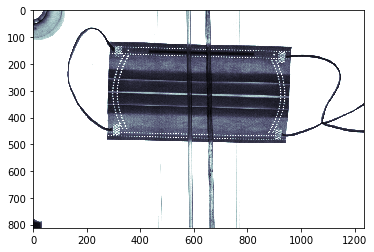

In [5]:
img = plt.imread(f'{PATH}耳带打结/{files[0]}')
plt.imshow(img,cmap='bone');

In [6]:
img.shape

(812, 1236)

## Using scripts from fast.ai course (new 2018 version, lesson1)

In [7]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [8]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [9]:
arch=resnet34
data = ImageClassifierData.from_paths('data', tfms=tfms_from_model(arch, sz),trn_name='缺陷原图', val_name='缺陷原图',num_workers=2)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.02, 10)

100%|██████████| 2/2 [00:17<00:00,  8.99s/it]


Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      3.287071   2.402992   0.015625  
    1      2.978444   2.002564   0.354167  
    2      2.605061   2.059817   0.25      
    3      2.432969   2.391581   0.273438  
    4      2.307589   2.515223   0.440104  
    5      2.11993    2.407719   0.296875  
    6      1.968417   2.164753   0.304688  
    7      1.931271   1.931218   0.463542  
    8      1.851229   1.749628   0.455729  
    9      1.796959   1.244366   0.502604  



[1.2443658, 0.5026041666666666]

## Now to review the train dataset and the results

First looking at the labels for the data, we started with 14 folders, and each image is assigned a label based on the folder.

In [10]:
data.val_y

array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  7,
        7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 13, 14, 14])

We can see the names of the classes

In [11]:
data.classes

['上部没包好边',
 '主体穿孔有破洞',
 '反正污渍图',
 '反面毛发',
 '叠片',
 '好品原图',
 '正面毛发图',
 '正面污渍图',
 '焊点位置不对',
 '焊点处有露头',
 '耳带打结',
 '耳带断裂',
 '耳带短',
 '鼻梁条歪斜',
 '鼻梁条短']

In [12]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(67, 15)

In [13]:
# this shows log probability for the first image
log_preds[:1]

array([[-3.0894 , -5.34038, -5.57552, -5.75961, -3.78552, -3.51697, -6.47946, -3.21518, -4.55992, -4.24782,
        -5.68621, -6.58224, -4.44381, -0.21481, -7.29202]], dtype=float32)

In [14]:
# predicted label for each image
preds = np.argmax(log_preds, axis=1)  
preds

array([13, 13,  9, 13,  2,  2,  3,  3,  4,  4,  5,  5,  5,  5, 13, 13,  5,  5,  5,  5,  5,  5,  5,  5,  5,
       13,  5,  5, 13,  5,  5, 13,  5,  5,  5,  5, 13,  5,  5,  5,  5,  5,  5,  5, 13,  5,  5,  7,  6,  7,
        7,  7, 13, 13, 13,  9, 13,  9,  5, 13, 13, 13, 13, 13, 13,  9,  9])

In [15]:
# probability for chosen category
probs = np.exp(np.max(log_preds,axis=1))
probs

array([0.8067 , 0.97304, 0.58863, 0.71718, 0.78264, 0.93473, 0.48346, 0.63549, 0.55552, 0.74844, 0.96697,
       0.95268, 0.96709, 0.804  , 0.55666, 0.78163, 0.7877 , 0.93735, 0.62554, 0.94168, 0.98881, 0.87917,
       0.73887, 0.98845, 0.98953, 0.62994, 0.78642, 0.94068, 0.61154, 0.93857, 0.8494 , 0.71137, 0.97721,
       0.82086, 0.99267, 0.96624, 0.51792, 0.94286, 0.98795, 0.70477, 0.8973 , 0.94114, 0.98381, 0.93916,
       0.37654, 0.95618, 0.92766, 0.96956, 0.25511, 0.97095, 0.99626, 0.9906 , 0.73707, 0.54421, 0.88128,
       0.51935, 0.89052, 0.39724, 0.58239, 0.85087, 0.82915, 0.49633, 0.97938, 0.85648, 0.97621, 0.60876,
       0.28206], dtype=float32)

In [16]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [17]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [18]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i],cmap='bone')

In [19]:
def load_img_id(ds, idx): return np.array(PIL.Image.open('data/'+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [20]:
data.val_ds.fnames

['缺陷原图/上部没包好边/1.tiff',
 '缺陷原图/上部没包好边/2.tiff',
 '缺陷原图/主体穿孔有破洞/1.tiff',
 '缺陷原图/主体穿孔有破洞/2.tiff',
 '缺陷原图/反正污渍图/原图.bmp',
 '缺陷原图/反正污渍图/原图1.bmp',
 '缺陷原图/反面毛发/原图.bmp',
 '缺陷原图/反面毛发/原图1.bmp',
 '缺陷原图/叠片/焊接时三片有交叠.tiff',
 '缺陷原图/叠片/二片叠在一起.tiff',
 '缺陷原图/好品原图/正面检测1.tiff',
 '缺陷原图/好品原图/正面检测18.tiff',
 '缺陷原图/好品原图/外形检测3.tiff',
 '缺陷原图/好品原图/反面检测1.tiff',
 '缺陷原图/好品原图/外形检测2.tiff',
 '缺陷原图/好品原图/外形检测5.tiff',
 '缺陷原图/好品原图/反面检测6.tiff',
 '缺陷原图/好品原图/反面检测10.tiff',
 '缺陷原图/好品原图/外形检测11.tiff',
 '缺陷原图/好品原图/正面检测7.tiff',
 '缺陷原图/好品原图/正面检测12.tiff',
 '缺陷原图/好品原图/外形检测9.tiff',
 '缺陷原图/好品原图/外形检测8.tiff',
 '缺陷原图/好品原图/正面检测6.tiff',
 '缺陷原图/好品原图/正面检测13.tiff',
 '缺陷原图/好品原图/外形检测10.tiff',
 '缺陷原图/好品原图/反面检测11.tiff',
 '缺陷原图/好品原图/反面检测7.tiff',
 '缺陷原图/好品原图/外形检测4.tiff',
 '缺陷原图/好品原图/反面检测12.tiff',
 '缺陷原图/好品原图/反面检测4.tiff',
 '缺陷原图/好品原图/外形检测7.tiff',
 '缺陷原图/好品原图/正面检测9.tiff',
 '缺陷原图/好品原图/反面检测8.tiff',
 '缺陷原图/好品原图/正面检测10.tiff',
 '缺陷原图/好品原图/正面检测5.tiff',
 '缺陷原图/好品原图/外形检测12.tiff',
 '缺陷原图/好品原图/正面检测11.tiff',
 '缺陷原图/好品原图/正面检测4.tiff',
 '缺陷原图/好品原图/反面检测9.tiff',
 '缺陷原图/

Correctly classified


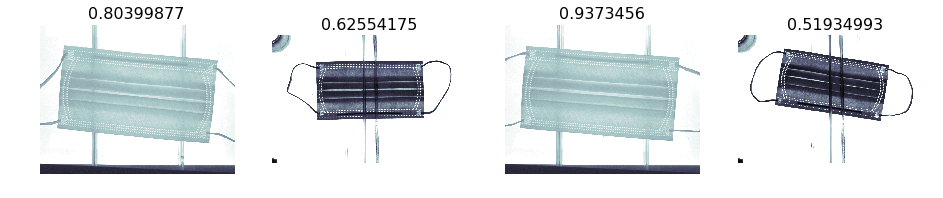

In [21]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


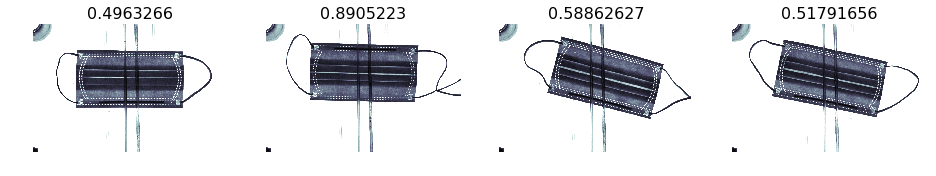

In [22]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")